In [38]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from catboost import CatBoostClassifier
import catboost as ctb


In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


In [82]:
#This data contains information about flight characteristics and the task is to tell if the fligth will be delayed for 15 or more min
train = pd.read_csv("flight_delays_train.csv")
test = pd.read_csv("flight_delays_test.csv")

In [41]:
train.shape

(100000, 9)

In [42]:
#Check missing values
train.isna().sum()

Month                0
DayofMonth           0
DayOfWeek            0
DepTime              0
UniqueCarrier        0
Origin               0
Dest                 0
Distance             0
dep_delayed_15min    0
dtype: int64

In [43]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


<AxesSubplot: ylabel='Month'>

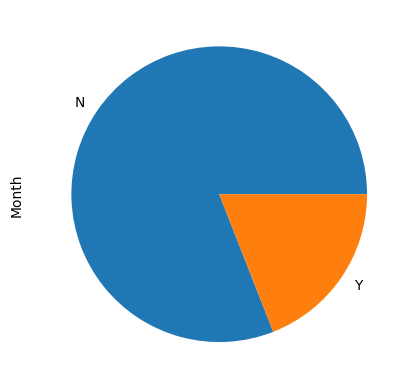

In [44]:
#Inspect the target variable. Unfortunately target variable is unbalanced.
train.groupby("dep_delayed_15min").count()["Month"].plot.pie()

<AxesSubplot: xlabel='Month'>

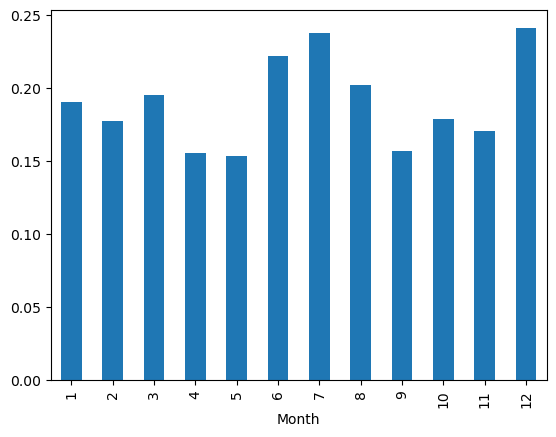

In [45]:
#Let's plot the data. We can see that more flights are delayed in summer and in december compared to other months
df = train.copy()
df.dep_delayed_15min = df.dep_delayed_15min.map({"Y":1, "N":0})
df.Month = pd.to_numeric(df.Month.str[2:])
df.groupby("Month")["dep_delayed_15min"].mean().plot(kind = "bar")

<AxesSubplot: xlabel='DayofMonth'>

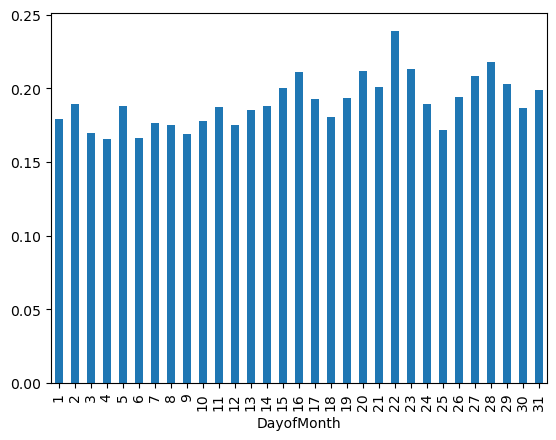

In [46]:
#It is not clear but more flights are delayed by the end of the month
df.DayofMonth = pd.to_numeric(df.DayofMonth.str[2:])
df.groupby("DayofMonth")["dep_delayed_15min"].mean().plot(kind = "bar")

<AxesSubplot: xlabel='DayOfWeek'>

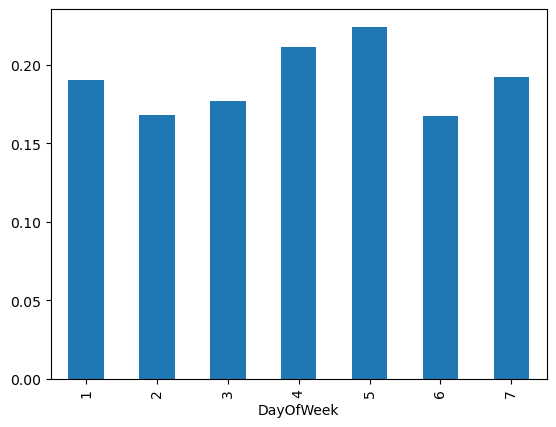

In [47]:
#Friday is the day when fligth is delayed mostly
df.DayOfWeek = pd.to_numeric(df.DayOfWeek.str[2:])
df.groupby("DayOfWeek")["dep_delayed_15min"].mean().plot(kind = "bar")

<AxesSubplot: xlabel='dep_delayed_15min', ylabel='Distance'>

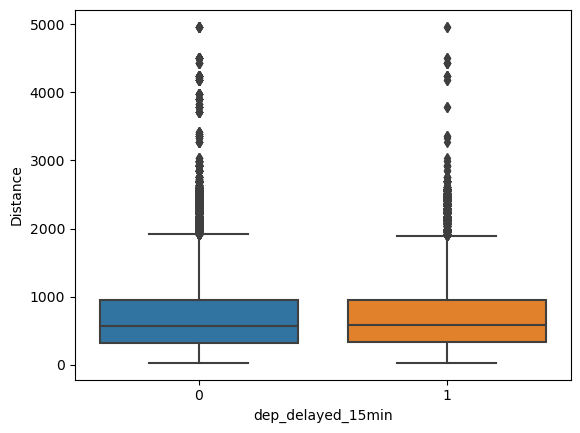

In [48]:
sns.boxplot(x = "dep_delayed_15min", y = "Distance", data = df)

<AxesSubplot: xlabel='dep_delayed_15min', ylabel='DepTime'>

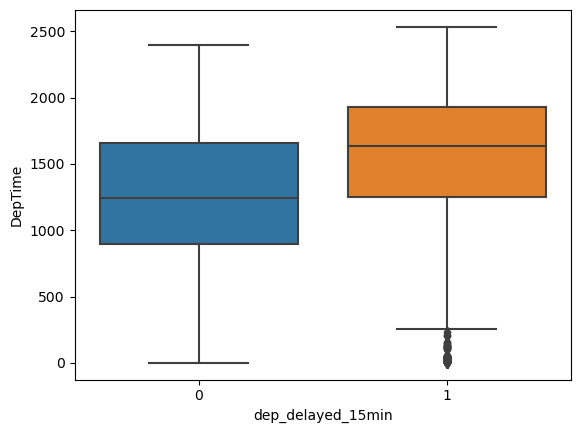

In [49]:
#Delayed flights' median value of departure time is greater compared to flights that has not been delayed. I guess that the longer flight is the liklihood of delying is increasing
sns.boxplot(x = "dep_delayed_15min", y = "DepTime", data = df)

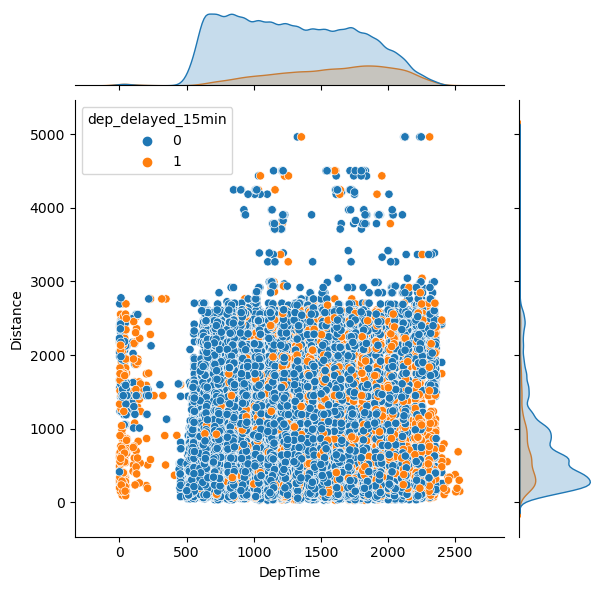

In [50]:
sns.jointplot(x = "DepTime", y = "Distance", data = df, hue = "dep_delayed_15min")

In [91]:
all_data = pd.concat([train,test])

In [92]:
#Create new variable "Way" that represent the combination of Origin and Destination of flights. Maybe some particualar roots are delayed mostly
all_data["way"] =  all_data["Origin"] + "_" +  all_data["Dest"]

In [93]:
#Another variable represents the combination of way and the Carrier
all_data["variable"] =  all_data["Origin"] + "_" +  all_data["Dest"] + "_"+ all_data["UniqueCarrier"]

In [94]:
train = all_data.iloc[:len(train),:]

In [95]:
test = all_data.iloc[len(test):,:].drop("dep_delayed_15min", axis = 1)

In [56]:
X = train.drop("dep_delayed_15min", axis = 1)

In [57]:
y = train["dep_delayed_15min"]


In [58]:
y = y.map({"N":0, "Y":1})

In [59]:
X.loc[:,X.dtypes==np.object].columns

C:\Users\paul\AppData\Local\Temp\ipykernel_7416\1816505594.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X.loc[:,X.dtypes==np.object].columns


Index(['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest',
       'way', 'variable'],
      dtype='object')

In [60]:
cat_features = list(X.loc[:,X.dtypes==np.object].columns)
print(cat_features)

['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest', 'way', 'variable']


C:\Users\paul\AppData\Local\Temp\ipykernel_7416\2385937528.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cat_features = list(X.loc[:,X.dtypes==np.object].columns)


In [112]:
#First model will not bee cross validated and the data will not be oversampled
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=17, stratify = y
)

In [113]:
clf = CatBoostClassifier(
    iterations=1000, 
    learning_rate=0.05, 
    loss_function='Logloss'
)


clf.fit(X_train, y_train, 
        cat_features=cat_features, 
        eval_set=(X_test, y_test), 
        verbose=True, early_stopping_rounds=10)

0:	learn: 0.6683367	test: 0.6682197	best: 0.6682197 (0)	total: 30.4ms	remaining: 30.3s
1:	learn: 0.6447492	test: 0.6446039	best: 0.6446039 (1)	total: 122ms	remaining: 1m 1s
2:	learn: 0.6244754	test: 0.6241903	best: 0.6241903 (2)	total: 159ms	remaining: 53s
3:	learn: 0.6070149	test: 0.6066406	best: 0.6066406 (3)	total: 185ms	remaining: 46s
4:	learn: 0.5909300	test: 0.5904156	best: 0.5904156 (4)	total: 213ms	remaining: 42.4s
5:	learn: 0.5755697	test: 0.5748066	best: 0.5748066 (5)	total: 290ms	remaining: 48s
6:	learn: 0.5635810	test: 0.5627424	best: 0.5627424 (6)	total: 333ms	remaining: 47.2s
7:	learn: 0.5515719	test: 0.5505384	best: 0.5505384 (7)	total: 417ms	remaining: 51.7s
8:	learn: 0.5410579	test: 0.5402079	best: 0.5402079 (8)	total: 487ms	remaining: 53.6s
9:	learn: 0.5310346	test: 0.5299448	best: 0.5299448 (9)	total: 554ms	remaining: 54.8s
10:	learn: 0.5229650	test: 0.5216504	best: 0.5216504 (10)	total: 614ms	remaining: 55.2s
11:	learn: 0.5162183	test: 0.5148120	best: 0.5148120 (11)

In [68]:
xgboost_predict_proba = clf.predict_proba(test)


In [69]:
len(xgboost_predict_proba)

100000

In [70]:
prob = [xgboost_predict_proba[i,1] for i in range(len(xgboost_predict_proba))]

In [71]:
my_submission = pd.DataFrame({"id": [i for i in range(0, len(test))],'dep_delayed_15min': prob})


my_submission.to_csv('cat.csv', index=False)

In [72]:
X.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,way,variable
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,ATL_DFW,ATL_DFW_AA
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,PIT_MCO,PIT_MCO_US
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,RDU_CLE,RDU_CLE_XE
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,DEN_MEM,DEN_MEM_OO
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,MDW_OMA,MDW_OMA_WN


In [114]:
#Sample tha data and model again
from imblearn.over_sampling import SMOTENC
smote_nc = SMOTENC(categorical_features=[0,1,2,4,5,6,8,9], random_state=0, sampling_strategy=0.24)
X_resampled, y_resampled = smote_nc.fit_resample(X, y)

In [115]:
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=17, stratify = y_resampled
)

In [116]:
clf = CatBoostClassifier(
    iterations=1000, 
    learning_rate=0.05, 
    loss_function='Logloss'
)


clf.fit(X_train_res, y_train_res, 
        cat_features=cat_features, 
        eval_set=(X_test_res, y_test_res), 
        verbose=True, early_stopping_rounds=10)

0:	learn: 0.6687915	test: 0.6687201	best: 0.6687201 (0)	total: 28.3ms	remaining: 28.3s
1:	learn: 0.6464840	test: 0.6462274	best: 0.6462274 (1)	total: 87.5ms	remaining: 43.7s
2:	learn: 0.6248830	test: 0.6244589	best: 0.6244589 (2)	total: 159ms	remaining: 53s
3:	learn: 0.6065518	test: 0.6059696	best: 0.6059696 (3)	total: 224ms	remaining: 55.7s
4:	learn: 0.5896539	test: 0.5887469	best: 0.5887469 (4)	total: 315ms	remaining: 1m 2s
5:	learn: 0.5751154	test: 0.5740612	best: 0.5740612 (5)	total: 385ms	remaining: 1m 3s
6:	learn: 0.5633392	test: 0.5621735	best: 0.5621735 (6)	total: 437ms	remaining: 1m 1s
7:	learn: 0.5527108	test: 0.5515151	best: 0.5515151 (7)	total: 463ms	remaining: 57.4s
8:	learn: 0.5426562	test: 0.5413472	best: 0.5413472 (8)	total: 526ms	remaining: 58s
9:	learn: 0.5330954	test: 0.5314776	best: 0.5314776 (9)	total: 604ms	remaining: 59.8s
10:	learn: 0.5248884	test: 0.5226946	best: 0.5226946 (10)	total: 699ms	remaining: 1m 2s
11:	learn: 0.5173038	test: 0.5147628	best: 0.5147628 (

In [77]:
#Model with over sample data showed a better score on test data but poorer result in kaggle benchmark
xgboost_predict_proba = clf.predict_proba(test)

In [78]:
prob = [xgboost_predict_proba[i,1] for i in range(len(xgboost_predict_proba))]

In [79]:
my_submission = pd.DataFrame({"id": [i for i in range(0, len(test))],'dep_delayed_15min': prob})

my_submission.to_csv('cat_over.csv', index=False)

In [117]:
#Now lets tune hyperparameters and model with unbalanced data
def objective(space):
    clf=CatBoostClassifier(n_estimators =space['n_estimators'], l2_leaf_reg = space['l2_leaf_reg'], max_depth = int(space["depth"]),
                    min_data_in_leaf = int(space['min_data_in_leaf']),random_strength=int(space['random_strength']),
                    learning_rate=space['learning_rate'],fold_len_multiplier =space['fold_len_multiplier']  ,cat_features=cat_features, loss_function='Logloss')
    
    evaluation = [( X_train, y_train), (X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation,
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred > 0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [118]:
space ={
        "n_estimators": 1000,
                
                'l2_leaf_reg' : hp.uniform('l2_leaf_reg', 0, 5),
                'min_data_in_leaf' : hp.quniform('min_data_in_leaf', 1, 50, 1),
                'random_strength' : hp.loguniform('random_strength', np.log(0.005), np.log(5)),
                'learning_rate' : hp.uniform('learning_rate', 0.01, 0.5),
                "depth" : hp.choice('max_depth', np.arange(3, 10, 1, dtype=int)),
                "objective": "multi:softprob",
                'fold_len_multiplier' : hp.loguniform('fold_len_multiplier', np.log(1.01), np.log(2.5)),
                'od_type' : 'Iter',
                'od_wait' : 25,
                'verbose' : 0}

In [119]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 10,
                        trials = trials)

SCORE:                                                                                                                 
0.8301333333333333                                                                                                     
SCORE:                                                                                                                 
0.8287333333333333                                                                                                     
SCORE:                                                                                                                 
0.8260333333333333                                                                                                     
SCORE:                                                                                                                 
0.8298333333333333                                                                                                     
SCORE:                                  

In [120]:
best_hyperparams

{'fold_len_multiplier': 1.2787670324969467,
 'l2_leaf_reg': 4.140479891901789,
 'learning_rate': 0.31867740291978325,
 'max_depth': 3,
 'min_data_in_leaf': 14.0,
 'random_strength': 0.02685188328797119}

In [121]:
best_ctb = CatBoostClassifier(**best_hyperparams, loss_function='Logloss')

In [122]:
best_ctb.fit(X_train, y_train, 
        cat_features=cat_features, 
        eval_set=(X_test, y_test), 
        verbose=True, early_stopping_rounds=10)

0:	learn: 0.5534423	test: 0.5519779	best: 0.5519779 (0)	total: 42.2ms	remaining: 42.2s
1:	learn: 0.4989554	test: 0.4974314	best: 0.4974314 (1)	total: 86.4ms	remaining: 43.1s
2:	learn: 0.4726899	test: 0.4700611	best: 0.4700611 (2)	total: 126ms	remaining: 41.8s
3:	learn: 0.4595773	test: 0.4564341	best: 0.4564341 (3)	total: 164ms	remaining: 40.9s
4:	learn: 0.4526002	test: 0.4487790	best: 0.4487790 (4)	total: 216ms	remaining: 42.9s
5:	learn: 0.4489063	test: 0.4449118	best: 0.4449118 (5)	total: 263ms	remaining: 43.6s
6:	learn: 0.4464339	test: 0.4424148	best: 0.4424148 (6)	total: 320ms	remaining: 45.3s
7:	learn: 0.4433491	test: 0.4393190	best: 0.4393190 (7)	total: 355ms	remaining: 44.1s
8:	learn: 0.4421109	test: 0.4374683	best: 0.4374683 (8)	total: 396ms	remaining: 43.6s
9:	learn: 0.4411461	test: 0.4364789	best: 0.4364789 (9)	total: 429ms	remaining: 42.4s
10:	learn: 0.4404422	test: 0.4357743	best: 0.4357743 (10)	total: 473ms	remaining: 42.6s
11:	learn: 0.4387222	test: 0.4338351	best: 0.43383

In [105]:
xgboost_predict_proba = best_ctb.predict_proba(test)


In [106]:
prob = [xgboost_predict_proba[i,1] for i in range(len(xgboost_predict_proba))]

In [107]:
my_submission = pd.DataFrame({"id": [i for i in range(0, len(test))],'dep_delayed_15min': prob})

my_submission.to_csv('cat_tune', index=False)

In [124]:
#Now lets tune hyperparameters and model with unbalanced data
def objective(space):
    clf=CatBoostClassifier(n_estimators =space['n_estimators'], l2_leaf_reg = space['l2_leaf_reg'], max_depth = int(space["depth"]),
                    min_data_in_leaf = int(space['min_data_in_leaf']),random_strength=int(space['random_strength']),
                    learning_rate=space['learning_rate'],fold_len_multiplier =space['fold_len_multiplier']  ,cat_features=cat_features, loss_function='Logloss')
    
    evaluation = [( X_train_res, y_train), (X_test_res, y_test_res)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation,
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test_res)
    accuracy = accuracy_score(y_test_res, pred > 0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [125]:
#Tune hyper params for oversampled data and compare the results
best_ctb = CatBoostClassifier(**best_hyperparams, loss_function='Logloss')
best_ctb.fit(X_train_res, y_train_res, 
        cat_features=cat_features, 
        eval_set=(X_test_res, y_test_res), 
        verbose=True, early_stopping_rounds=10)

0:	learn: 0.5556418	test: 0.5544901	best: 0.5544901 (0)	total: 42ms	remaining: 41.9s
1:	learn: 0.5022455	test: 0.5005291	best: 0.5005291 (1)	total: 80.7ms	remaining: 40.3s
2:	learn: 0.4761022	test: 0.4738818	best: 0.4738818 (2)	total: 136ms	remaining: 45.2s
3:	learn: 0.4627158	test: 0.4603772	best: 0.4603772 (3)	total: 182ms	remaining: 45.2s
4:	learn: 0.4574444	test: 0.4551367	best: 0.4551367 (4)	total: 228ms	remaining: 45.3s
5:	learn: 0.4538026	test: 0.4513710	best: 0.4513710 (5)	total: 279ms	remaining: 46.1s
6:	learn: 0.4520104	test: 0.4494832	best: 0.4494832 (6)	total: 319ms	remaining: 45.2s
7:	learn: 0.4499968	test: 0.4470702	best: 0.4470702 (7)	total: 361ms	remaining: 44.7s
8:	learn: 0.4473653	test: 0.4437401	best: 0.4437401 (8)	total: 409ms	remaining: 45s
9:	learn: 0.4462671	test: 0.4425600	best: 0.4425600 (9)	total: 445ms	remaining: 44s
10:	learn: 0.4443347	test: 0.4407377	best: 0.4407377 (10)	total: 485ms	remaining: 43.6s
11:	learn: 0.4432180	test: 0.4390252	best: 0.4390252 (11

In [ ]:
#The best model was resmapled data without tuning  because it has the best score on the test data